# Постановка задачи

Обучаем на небольшом кусочке реальных данных. И на таком же небольшом тестируем

Так будет быстрее и проще. Сходу большой сложный датасет не взять - и долго и в плюс так и не вышли.

# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import random
import warnings
import ipynbname
import logging.config
import cProfile, pstats

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
TS_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/telegram_send/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

gen12.3-Stock-g11


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

%matplotlib notebook

In [3]:
# NN Frameworks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model, clone_model

2023-09-29 20:51:55.793178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# RT packages
from rl import DQNAgent
from env import TradeEnv

from core_v2 import Constructor, Player
from core_v2.data_point import DataPointFactory
from core_v2.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from train_tools import TrainManager, TrainPlot4, TelegramSend
from train_tools import plot_and_go, distribution_analysis, get_max_step_factor

In [5]:
seed_value= 0
#os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
#np.random.seed(seed_value)
#tf.random.set_seed(seed_value)

# Конфиг

In [6]:
dataset_config = {
    "period": 300
}

#Конфиг для предварительного обсчета датасета
orderbook_levels = [0.001, 0.0025, 0.005, 0.01]

# Датасет

<IPython.core.display.Javascript object>


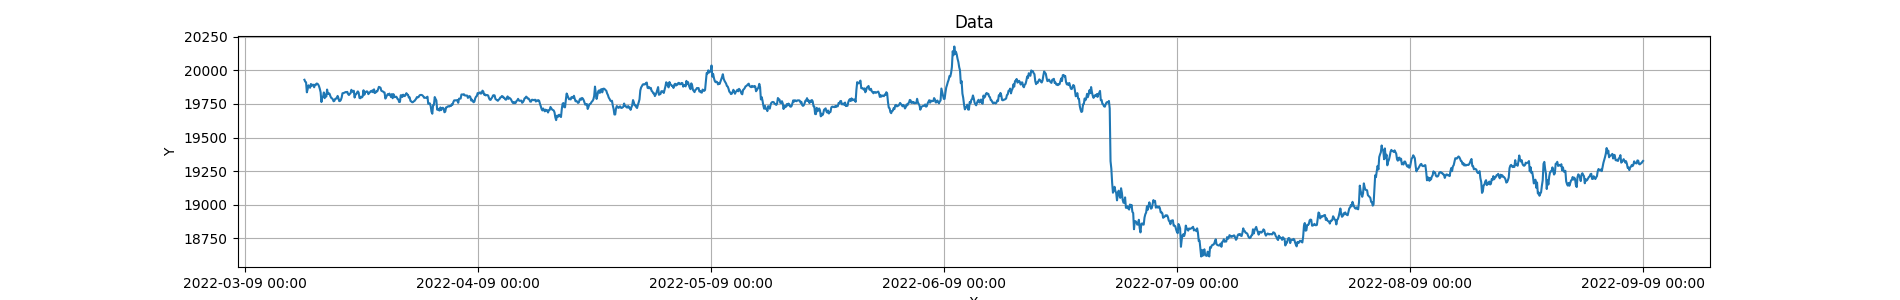

(1655, 19)


In [7]:
path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-train.csv"

data_1 = pd.read_csv(path, index_col='ts')

#data_1 = data_1.iloc[1700:2800, :]  # fast test
#data_1 = data_1.iloc[650:1450, :]  # fast train
plot_and_go(data_1, title="Data", fig_x=19, fig_y=3, dpi=50)

precompute = PrecomputeOrderbookDiffFeature()
for level in orderbook_levels:
    data_1 = precompute.process(data_1, level)

<IPython.core.display.Javascript object>


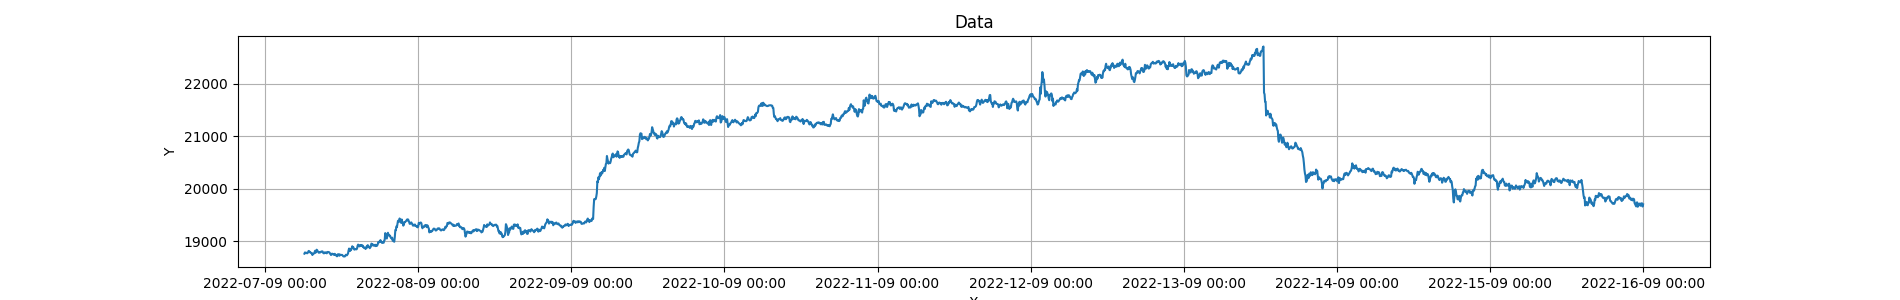

(2519, 19)


In [8]:
path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/03.BTC_USDT-300-test.csv"

data_2 = pd.read_csv(path, index_col='ts')
#data_2 = data_2.iloc[700:1500, :] # fast test
#data_2 = data_2.iloc[300:650, :] # fast check
plot_and_go(data_2, title="Data", fig_x=19, fig_y=3, dpi=50)

precompute = PrecomputeOrderbookDiffFeature()
for level in orderbook_levels:
    data_2 = precompute.process(data_2, level)

# Инициализация компонентов

## Core

In [9]:
core_config = {
    "action_controller":{"class": "BasicTrainController", "params":{ 
            "penalty": -2, 
            "market_fee": 0.0015,
            "wait_scale": 0, 
            "open_scale": 0, 
            "hold_scale": 0, 
            "close_scale": 100, 
            "last_points_mean": 2
        },},

    "observation_builder":{
        "class": "ObservationBuilder",
        "inputs": [
            {"class": "Input1D", "features": [{"class": "RawContextFeature", "params": {"name":"is_open"}}]},
            {"class": "Input2D", "features": [
                {"class": "RatesFeature", "params": {"step_factor":1, "scale_output": 30}},
                {"class": "RatesFeature", "params": {"step_factor":3, "scale_output": 30}},
                {"class": "RatesFeature", "params": {"step_factor":12, "scale_output": 30}},
                                
                {"class": "ProfitFeature", "params": {"step_factor":1, "scale_output": 30, "normalization":False, "clip_output":False}},
                
                #{"class": "TradeVolumes", "params": {"step_factor":1, "scale_output": 0.2, "clip_output":2}},
                #{"class": "TradeCount", "params": {"step_factor":1, "scale_output": 0.2, "clip_output":2}},
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.001, "scale_output": 0.3}},                               
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.0025, "scale_output": 0.3}},                                 
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.005, "scale_output": 0.3}},                                 
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.01, "scale_output": 0.3}},                                 
                

            ]}
        ]
    }
}
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
core_constructor = Constructor()
env_core = core_constructor.get_core(ALIAS, core_config)

## Datapoint factory

In [10]:
# Параметры точки наблюдения
observation_len = 30
step_size = 1
offset =  get_max_step_factor(core_config) * observation_len + 1

dp_factory_config = {
    "observation_len": observation_len,                            # Количество точек наблюдения в сэмпле
    "offset": offset,                                 # Хвост исторических данных
    "future_points": 0,                               # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": step_size                                    # Шаг по датасет
 }

dpf_train = DataPointFactory(dataset=data_1, **dp_factory_config, alias='train')
dpf_test = DataPointFactory(dataset=data_2, **dp_factory_config, alias='test')

In [11]:
dpf_train.get_max_steps()

1294

<IPython.core.display.Javascript object>


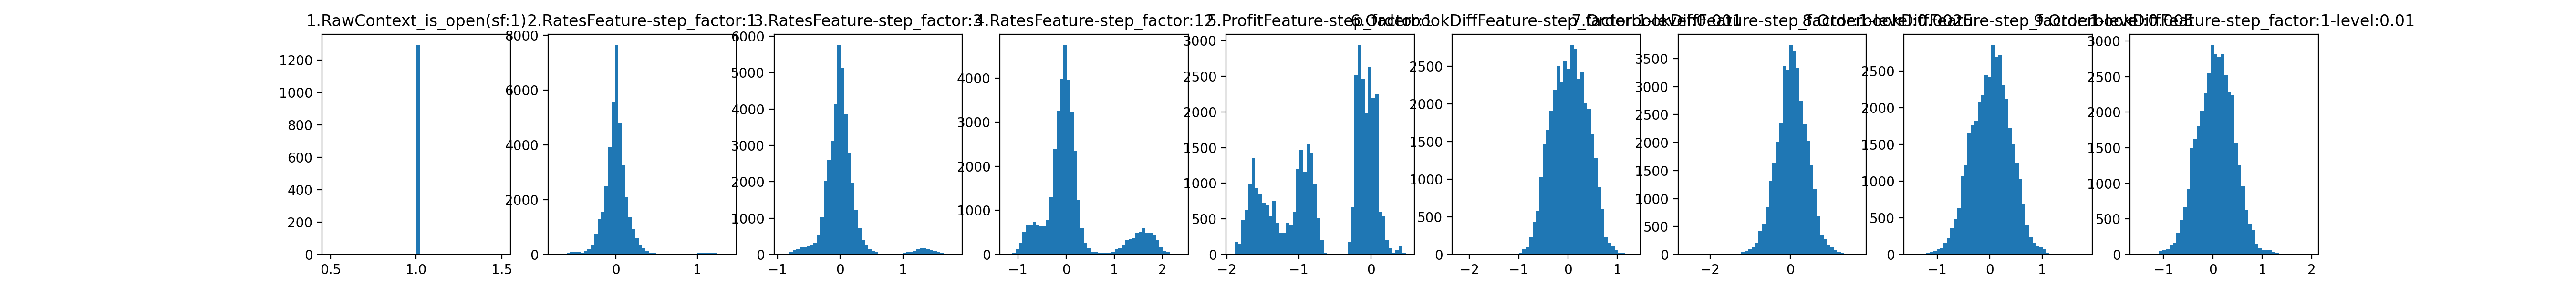

In [12]:
data = distribution_analysis(dpf_train, env_core, trade_every=50, plot_x_size=3, plot_y_size=3)

# Нейронная сеть

In [13]:
env = TradeEnv(env_core, dpf_train, alias=ALIAS, log=False, log_obs=False)

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

ACTIVATION = 'elu'
def create_q_model(env):
    num_actions = env.action_space
    #----------------------------------------------

    inp_static = Input(shape=env.observation_space[0])

    inp_timesteps = Input(shape=env.observation_space[1])
    conv_ts = Conv1D(filters=64, kernel_size=7, strides=1, padding="same", input_shape=env.observation_space[1], activation=ACTIVATION)(inp_timesteps)
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    conv_ts = Conv1D(filters=128, kernel_size=5, strides=1, padding="same", activation=ACTIVATION)(conv_ts)    
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    flt_ts = Flatten()(conv_ts)

    classif = Concatenate()([inp_static, flt_ts])

    classif = Dense(1024, activation=ACTIVATION)(classif)
    classif = Dense(1024, activation=ACTIVATION)(classif)

    #classif = Dropout(0.3)(classif)

    output = Dense(num_actions, activation='softmax')(classif)

    model = Model(inputs=[inp_static, inp_timesteps], outputs=output)
    return model
model = create_q_model(env)
model_target = create_q_model(env)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 8)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 30, 64)       3648        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 15, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 15, 128)      41088       ['max_pooling1d[0][0]']          
                                                                                              

2023-09-29 20:52:10.240361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Обучение

In [14]:
random.seed(seed_value)

core_train = core_constructor.get_core("train", core_config)
env = TradeEnv(core_train, dpf_train, alias=ALIAS, log=False, log_obs=False)

model = create_q_model(env)
model_target = create_q_model(env)
agent = DQNAgent(env, model, model_target)

agent.epsilon_random_frames = 6000   #(5% = 650)
agent.epsilon_greedy_frames = 129400 #(100% = 25000)
agent.max_memory_length     = 25000  #(20% = 2600)
agent.max_steps_per_episode = 50000
agent.gamma = 0.99
agent.epsilon_min = 0.01
agent.batch_size = 32
agent.update_after_actions = 4
agent.update_target_network = 1294   #(1% = 130)
agent.loss_function = tf.keras.losses.Huber() # #tf.keras.losses.Huber() #tf.keras.losses.MeanSquaredError()
agent.optimizer = Adam(learning_rate=0.00025)    #Adam(learning_rate=learning_rate) RMSprop(learning_rate=learning_rate) SGD(learning_rate=learning_rate)


tp = TrainPlot4()
core_test = core_constructor.get_core("test", core_config)
tm = TrainManager(agent, core_test, dpf_test, tp, alias=ALIAS)
tm.load_snapshot("last_state")

Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
Снепшот успешно загружен на эпизоде 1161


In [15]:
tp.init_plot(width=1000, height=800)
tp.update_plot(tm.history)

FigureWidget({
    'data': [{'legendgroup': '1',
              'line': {'color': '#109618', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': 'a77f4db0-8545-44d5-b174-54b5f7369cb6',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '1',
              'line': {'color': '#FF9900', 'width': 1},
              'mode': 'lines',
              'name': 'Test',
              'type': 'scatter',
              'uid': 'b0b978d5-ac32-49b0-8abc-5bb155fb148c',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '2',
              'line': {'color': 'rgb(179,222,105)', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '39844603-9d80-4b6b-8787-0ffa7fc0d78a',
              'xaxis': 'x',
              'yaxis': 'y2'},
             {'legendgroup': '2',
              'line': {'color': '

In [16]:
tm.test_every = 5000
tm.update_plot_every = 5000
tm.save_test_since = 0.08
tm.save_train_since = 0.13

tm.go(max_frames=2500000)

20:52:36 Running reward: -7.28    at episode 1162 | frame 1501040 | eps: 0.01 | Running loss: 0.00766
20:53:05 Running reward: -7.18    at episode 1163 | frame 1502334 | eps: 0.01 | Running loss: 0.00775
20:53:34 Running reward: -7.30    at episode 1164 | frame 1503628 | eps: 0.01 | Running loss: 0.00770
20:54:03 Running reward: -7.89    at episode 1165 | frame 1504922 | eps: 0.01 | Running loss: 0.00766
20:54:41 Running reward: -7.53    at episode 1166 | frame 1506216 | eps: 0.01 | Running loss: 0.00770
20:55:10 Running reward: -8.12    at episode 1167 | frame 1507510 | eps: 0.01 | Running loss: 0.00763
20:55:39 Running reward: -7.91    at episode 1168 | frame 1508804 | eps: 0.01 | Running loss: 0.00763
Finished at frame 1510000


In [17]:
tm.drop_snapshots(name="test", threshold=0.07)

0 files with a capacity of 0 Mb were deleted


# Итоги
1. Копия g11 на данных g11 не смог повторить результат - нестабильно, нет нормальных реззультатов на тесте, склонен всегда держать позицию открытой
    - gamma=0.97 - сильный расколбас. Мимо кассы
    - rewardScale=50 - разброс по sparcity стал больше.
    - rewardScale=250 - разброс по sparcity стал меньше, график показывает боольше стабильности. Прогон через player показвывает отличные графики;
    - rewardScale=350 и 500 - случается "передоз" и на тесте перестает торговать. Тренировочный датасет не выходит выше нуля.
    - FeatureScale=0.5x - показывает себя лучше чем базовый конфиг. Тренировочный стабилен на уровне 14-16 процентов и достаточно неплохо выглядит sparcity
    - FeatureScale=0.3x - хуже варианта 0.5x по результативночти и спарсити
    
    
Пока 2 интересных тренда - FeatureScale 0.5х показало себя неплохо и увеличенеи награды

# Test

In [20]:
tm.get_stat(name="train", top_n=50)

Profit: 15.53% | id: 758991   | Penalties: 8    | TotalReward: -0.47    Sparsity 0.43 |  [ ] 
Profit: 15.38% | id: 1141719  | Penalties: 10   | TotalReward: -4.62    Sparsity 0.46 |  [ ] 
Profit: 15.27% | id: 1166286  | Penalties: 11   | TotalReward: -6.73    Sparsity 0.46 |  [ ] 
Profit: 15.24% | id: 627105   | Penalties: 9    | TotalReward: -2.76    Sparsity 0.45 |  [ ] 
Profit: 15.21% | id: 1083534  | Penalties: 9    | TotalReward: -2.79    Sparsity 0.50 |  [ ] 
Profit: 15.20% | id: 1092585  | Penalties: 7    | TotalReward: 1.20     Sparsity 0.46 |  [ ] 
Profit: 15.12% | id: 1082241  | Penalties: 4    | TotalReward: 7.12     Sparsity 0.44 |  [ ] 
Profit: 15.07% | id: 1471434  | Penalties: 5    | TotalReward: 5.07     Sparsity 0.50 |  [ ] 
Profit: 15.06% | id: 1318860  | Penalties: 12   | TotalReward: -8.94    Sparsity 0.52 |  [ ] 
Profit: 14.94% | id: 1448160  | Penalties: 5    | TotalReward: 4.94     Sparsity 0.51 |  [ ] 
Profit: 14.87% | id: 1298172  | Penalties: 10   | TotalRewar

<IPython.core.display.Javascript object>


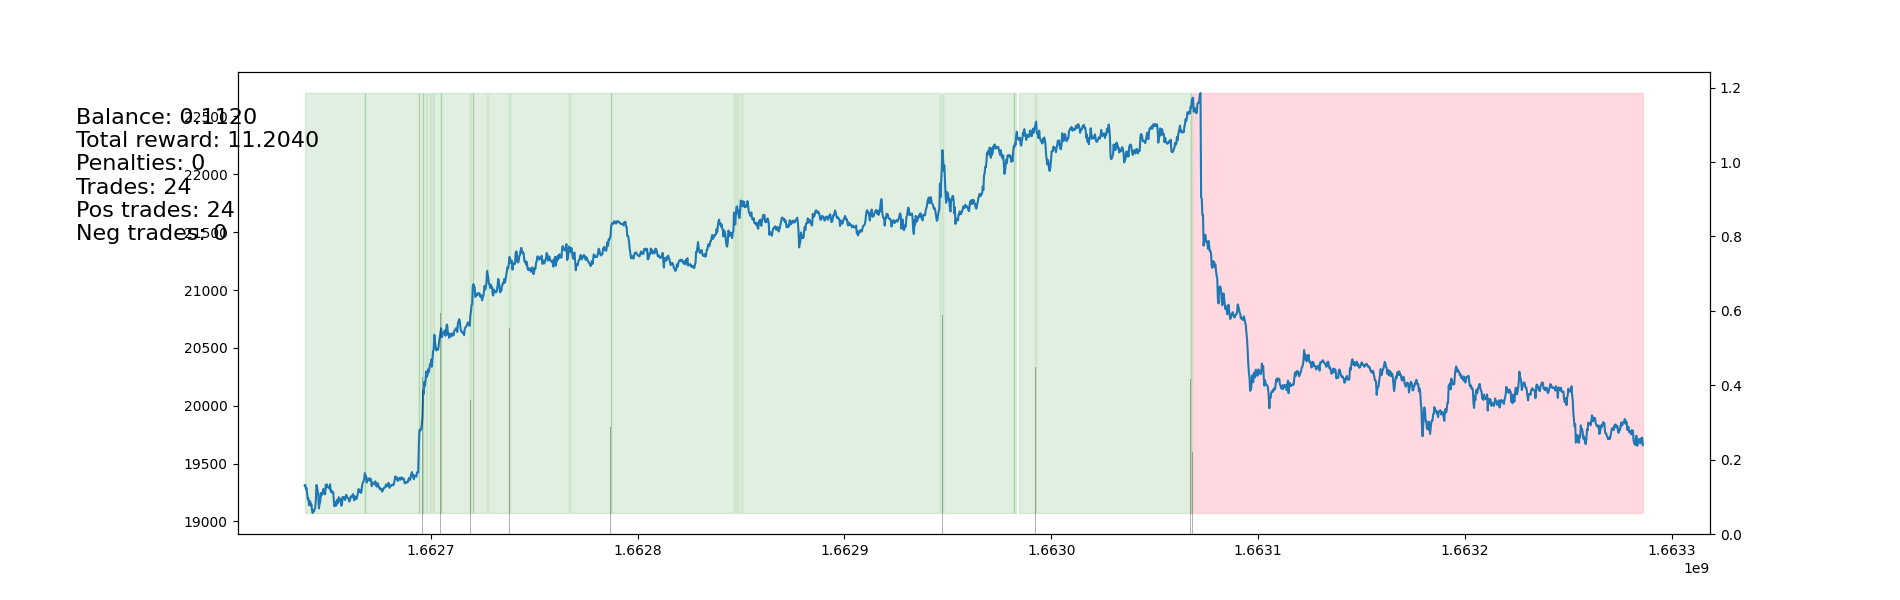

In [20]:
# max_id
model_id = 275000
model_test = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_test, dpf_test)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


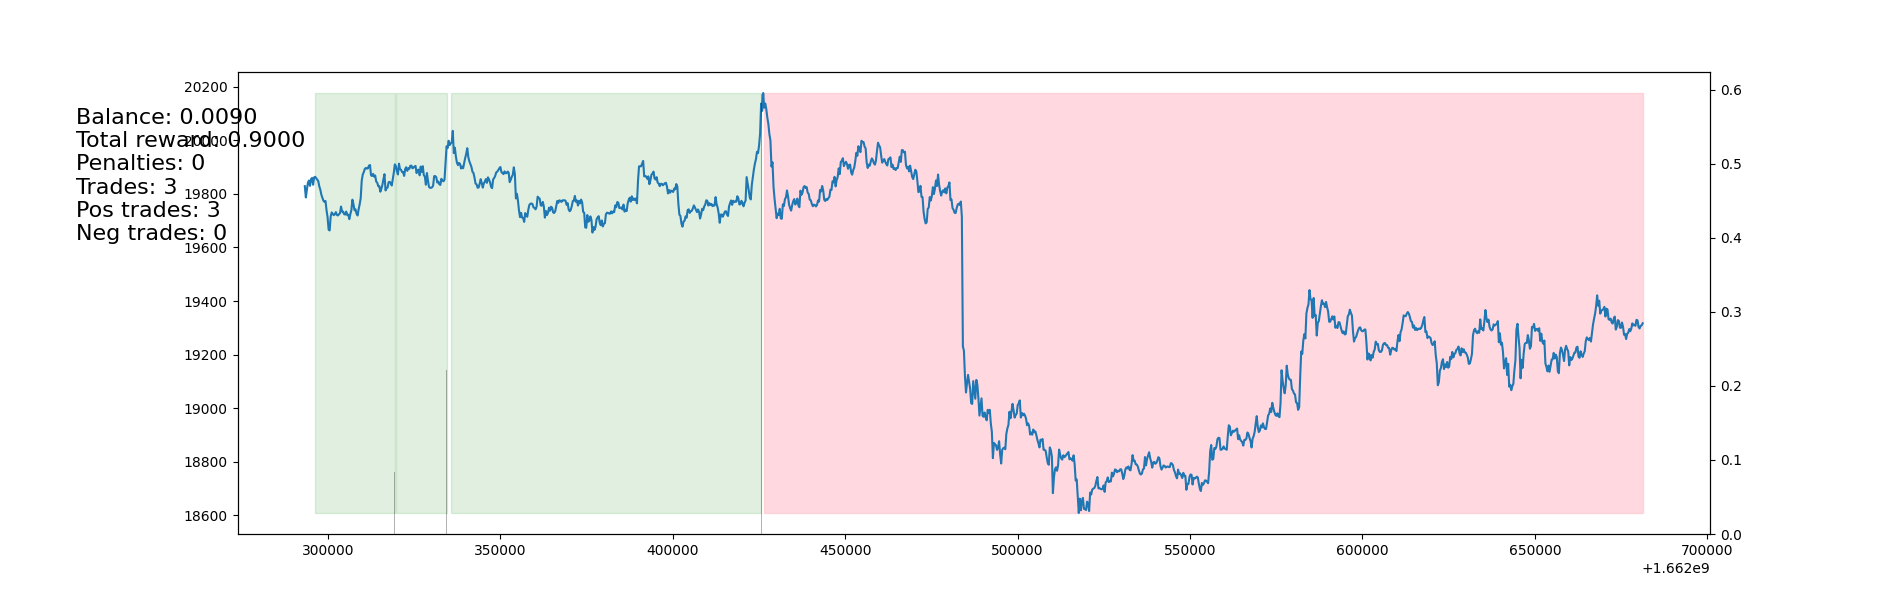

In [21]:
#model_id = 105000
#model_test = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_test, dpf_train)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

## Итоги

Базовый конфиг - смог обучиться и получить лучший результат на тесте, но стабильности не было - встречались колебания (с этим надо бороться).

Конфиг:
 - Датасет: 30 наблюдений
 - Ядро
     - wait=10|open=0|hold=10|close=10
     - num_mean_obs=1, market_fee=0
 - Сеть: 
     - CNN(f96, k5, s1)-MaxPool(3)-CNN(f128, k3, s1)-MaxPool(2)
     - Flatten
     - Dense(512/do=0.3)-Dense(384/do=0.3)-Dense(256/do=0.3)
 - Агент:
     - greedy_frames=25k, random_frames=1000, memory_length=25000, eps_min=0.01
     - gamma = 0.975, batch_size = 32, uaa=4, utn=1000
     - loss=Huber, optimizer=Adam(learning_rate=0.0001, clipnorm=0.001)

Конфиг справился с задачей, но на тесте была просадка, потом выправился. 

----
1. Тест utn (1000) - выглядит так, что можно поставить utn побольше - на 1500 и 3000 нет локальной просадки, максимальные результаты такие же.
    - 250 и 500 - волны на тесте. тренировочный график, как ни странно - ровный.
    - 1500 и 3000 чуть стабильнее базового конфига (1000)
    
2. Тест learning_rate (0.0001) - текущее значение выглядит оптимальным.
    - 0.00005 - судя по графику, похоже, что обучался в 2х дольше, чем с базовым ЛР (0.0001)
    - 0.00025/0.0005/0.001 - результаты те же, но больше нестабильности.

3. Тест gamma(0.975) - текущее значение выглядит оптимальным (в сочетании с коэффициентами награды).
     - 0.95 - результаты нестабильны - то справляется отлично, то начинает частить и сильно не попадает в такт.
     - 0.99 - очень стабильно, но результаты не оптимальны, теряет 30-40% профита из-за частой торговли
----

4. Тест разных масштабов награды
    - пробовал 30х, 60х, 100х, 150х
    - Более высокие значения приводят к стабилизации обучения - нет провалов.
    - Часто торгует, максимальной награды не получить.
    - На 30х и 60х возрастает количество BadAction. (проблема!)
    - При увеличении penalty до -2 на 30х сократилось количество штрафов (но в ноль не ушло). Штраф -5 - (жду завершения обучения)
    
Надо увеличить штраф за неправильное действие

    

## Итоги
Базовый конфиг не сработал - обучение на небольшом куске данных провалилось. Нет стабильности и нет намеков на "понимание" данных
Возможно, он реагирует на награду в ожидании и "переключает" сделку 

----

Уменьшил scale_wait и  scale_hold с 15 до 5, и увеличил scale_close с 7 до 30 -  за 250к ничего вменяемого :(. Надо смотреть в другом направлении.

С наградой только за закрытие (обнулил scale_wait и  scale_hold) тоже фигня.

----
Пробуем сделать gamma 0.99 - так раньше работало... За 400к фреймов ничего хорошего. Была полка на тренировочном датасете на уровне 5-6 процентов, но тест всегда в ауте. Потом и полка сошла на нет.

увеличил scale_close с 30 до 100 и прогнал 3.5 млн фреймов:
 - Результат стабилен после 1 млн, но разброс имеется и хотелось бы поменьше. 
 - Со 100к (min eps) и до 250 был провал, потом вышел на "оптимум"
 - Действия адексватны
 - train и test идут параллельно. Тест ниже нуля.
 - Плохие результаты на тесте обулословлены тем, что не реагирует на провалы.
 
что с этим делать - хз. Надо экспериментировать. Вижу 2 варианта: попробовать увеличить награду за ожидание и сделать наблюдение короче и шире

----
Увеличил награду за ожидание с 5 до 40 на предыдущем конфиге - общая стабильность выросла, тест стал чуть лчше, но все равно уже нуля.

Уменьшил observation_len с 30 до 20 и добавил еще одну фичу со step_factor=9 - расколбас на тренировочном датасете (спарсити от 20 до 50%), тест ниже нуля. Это плохо.

----
Прочие мысли: статичная награда за hold не покрывает кейс, когда мы продолбались - был сильный провал, операция открыта, мы в минусе, но пофмали локальны подъем и за него получаем положительную награду. 

Идея (подумать) - давать награду в зависимости от общего профита? Т.е. когда мы в плюсе - давать либо все, либо только положительные  шаги, когда мы в минусе - давать только минус, либо ничего.






